## Домашняя работа «Оценка точности модели, переобучение, регуляризация» обновленное

In [102]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from numpy import arange
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve

1. Преобразуйте данные

a. проверьте наличие пропущенных значений. Преобразуйте/удалите пропуски по необходимости;

b. закодируйте категориальные переменные числовыми значениями по необходимости.

In [103]:
data = pd.read_csv("athletes.csv")

In [104]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11538 non-null  int64  
 1   name         11538 non-null  object 
 2   nationality  11538 non-null  object 
 3   sex          11538 non-null  object 
 4   dob          11537 non-null  object 
 5   height       11208 non-null  float64
 6   weight       10879 non-null  float64
 7   sport        11538 non-null  object 
 8   gold         11538 non-null  int64  
 9   silver       11538 non-null  int64  
 10  bronze       11538 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 991.7+ KB


In [105]:
data.head(15)

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0
5,173071782,Aaron Royle,AUS,male,1/26/90,1.80,67.0,triathlon,0,0,0
6,266237702,Aaron Russell,USA,male,6/4/93,2.05,98.0,volleyball,0,0,1
7,382571888,Aaron Younger,AUS,male,9/25/91,1.93,100.0,aquatics,0,0,0
8,87689776,Aauri Lorena Bokesa,ESP,female,12/14/88,1.80,62.0,athletics,0,0,0
9,997877719,Ababel Yeshaneh,ETH,female,7/22/91,1.65,54.0,athletics,0,0,0


проверим, в каких атрибутах у нас есть пустые строки, исключая атрибут sex (я буду использовать его, как целевой) и незначимый атрибут id
часть строк может иметь пустые атрибуты в нескольких полях, поэтому целесообразно постепенно удалять строки с пустыми значениями и проверять значение Non-Null count в выводе df.info()

In [106]:
print('Для height пустых строк ' + str( len( data[ pd.isnull( data['height'] ) ] ) ))
print('Для weight пустых строк ' + str( len( data[ pd.isnull( data['weight'] ) ] ) ))
print('Всего строк в наборе ' + str( len( data ) ))

Для height пустых строк 330
Для weight пустых строк 659
Всего строк в наборе 11538


попробуем удалить такие строки для роста и веса

In [107]:
data = data[ pd.isnull( data['height'] ) == 0 ]
data = data[ pd.isnull( data['weight'] ) == 0 ]

In [108]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10858 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           10858 non-null  int64  
 1   name         10858 non-null  object 
 2   nationality  10858 non-null  object 
 3   sex          10858 non-null  object 
 4   dob          10858 non-null  object 
 5   height       10858 non-null  float64
 6   weight       10858 non-null  float64
 7   sport        10858 non-null  object 
 8   gold         10858 non-null  int64  
 9   silver       10858 non-null  int64  
 10  bronze       10858 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 1017.9+ KB


Этого оказалось достаточно, во всех атрибутах непустые строки, значит, остальные пустые значения просто совпадали в строках

Нужно решить, что еще я не буду использовать для модели. Понятно, что имя и дату рождения нецелесообразно, они уникальны или почти уникальны, а также разумно предположить, что трудно ожидать от них влияния на модель. Проверю уникальность значений для других полей

In [109]:
print(len(data['nationality'].unique()))
print(len(data['height'].unique()))
print(len(data['weight'].unique()))
print(len(data['sport'].unique()))

200
82
123
27


Многовато. На продуктиве, если этого требует задача, вполне можно было бы их трансформировать с помощью data = pd.get_dummies(data, columns=cat_columns), и у меня получилось бы ну очень много атрибутов для модели, но для учебных целей можно просто не использовать категориальные признаки

In [110]:
X = data[['height', 'weight', 'gold', 'silver', 'bronze']]
X.head(5)

,height,weight,gold,silver,bronze
0,1.72,64.0,0,0,0
1,1.68,56.0,0,0,0
2,1.98,79.0,0,0,1
3,1.83,80.0,0,0,0
4,1.81,71.0,0,0,0


2. Разделите выборку на обучающее (80% данных) и тестовое (20% данных) подмножества.

исходные данные для модели:

In [111]:
#X определен выше
le = LabelEncoder()
le.fit(data['sex'])
y = pd.Series(data = le.transform(data['sex']))
y.head(5)

0    1
1    0
2    1
3    1
4    1
dtype: int64

делим выборку

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

3. Постройте ROC-кривую с помощью функции sklearn.metrics. roc_curve.

построим для этого модель

In [113]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [114]:
predictions = model.predict_proba(X_test)
fpr, tpr, thresh = roc_curve(y_test, predictions[:,1])

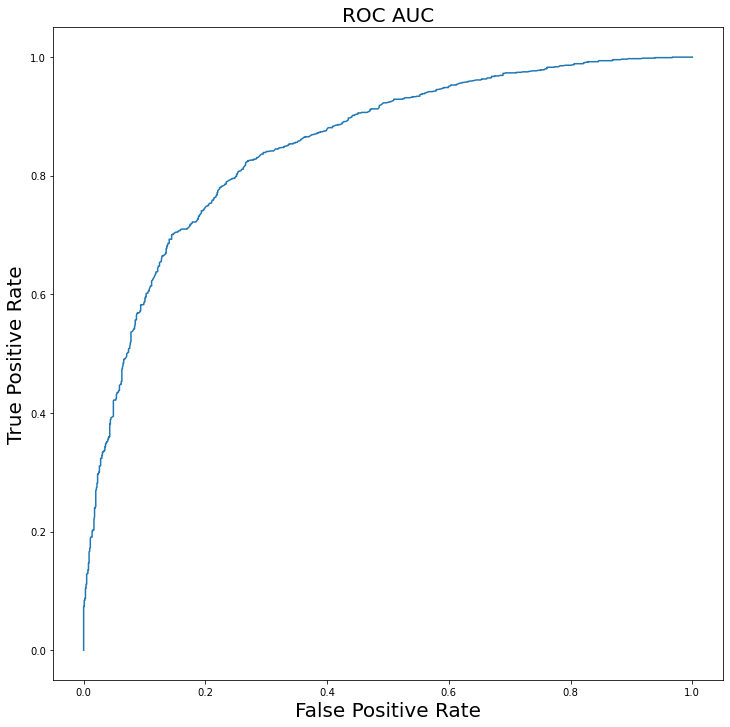

In [115]:
plt.figure(figsize=(12, 12))
plt.plot(fpr, tpr)
plt.title('ROC AUC', fontdict={'fontsize': 20})
plt.xlabel('False Positive Rate', fontdict={'fontsize': 20})
plt.ylabel('True Positive Rate', fontdict={'fontsize': 20})
plt.show()

4. Вычислите значение ROC-AUC метрики с помощью функции sklearn.metrics.roc_auc_score.

In [116]:
roc_auc_score(y_test, predictions[:, 1])

0.8504375666840369

5. Реализуйте подсчет метрик TPR, FPR «вручную», без использования готовых функций из библиотеки sklearn.
6. Постройте ROC-кривую с помощью вычисленных в п. 5 метрик: объедините графики из п. 3 и п. 6 в один. Сравните, сделайте вывод.
7. Постройте график Precision-Recall, используя метрики, посчитанные в п. 5.
8. *Вычислите значение ROC-AUC метрики, используя метрики, посчитанные в п. 5.

In [144]:
thresholds = arange(0, 1, 0.1)
#predictions определены выше
fprs = []
tprs = []
prs = []
res = []
pr_custom = []
for threshold in thresholds:
    tp = 0 # True positive
    fp = 0 # False positive
    fn = 0 # False negative
    tn = 0 # True negative
    for predicted_prob, actual in zip( predictions[:, 1], y_test ):
        if predicted_prob >= threshold:
            predicted = 1
        else:
            predicted = 0

        if predicted == 1:
            if actual == 1:
                tp += 1
            else:
                fp += 1

        else:
            if actual == 1:
                fn += 1
            else:
                tn += 1
    tpr2 = tp/(tp + fn)
    fpr2 = fp/(fp + tn)
    precision = tp/(tp + fp)
    recall = tpr2 #по определению
    fprs.append(fpr2)
    tprs.append(tpr2)
    prs.append(precision)
    res.append(recall)


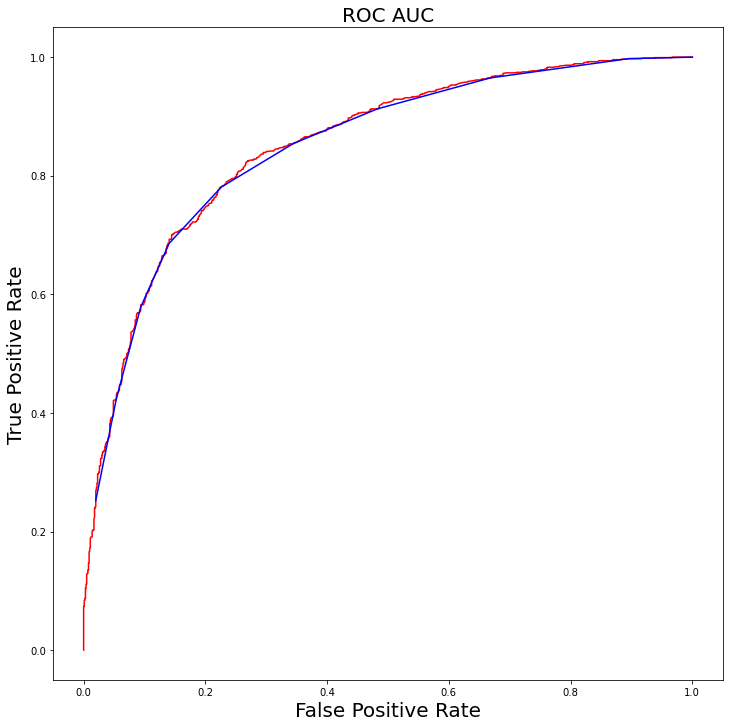

In [145]:
plt.figure(figsize=(12, 12))
plt.plot(fpr, tpr, color="red")
plt.plot(fprs, tprs, color="blue")
plt.title('ROC AUC', fontdict={'fontsize': 20})
plt.xlabel('False Positive Rate', fontdict={'fontsize': 20})
plt.ylabel('True Positive Rate', fontdict={'fontsize': 20})
plt.show()

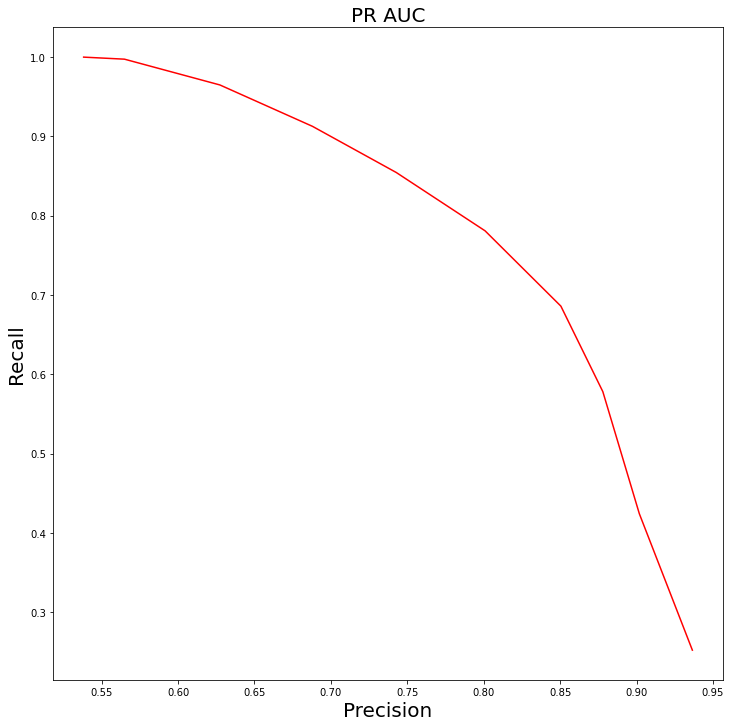

In [146]:
plt.figure(figsize=(12, 12))
plt.plot(prs, res, color="red")
plt.title('PR AUC', fontdict={'fontsize': 20})
plt.xlabel('Precision', fontdict={'fontsize': 20})
plt.ylabel('Recall', fontdict={'fontsize': 20})
plt.show()

In [155]:
#сортируем по возрастанию, чтобы считать от начала кривой
fprs.sort()
tprs.sort()
#кастомная метрика roc_auc - аналог roc_auc_score, очень приблизительно моделируем площадь фигуры как сумму фигур по шагам
custom_roc_auc = 0
prev_fpr = 0
prev_tpr = 0
for index in range(len(fprs)):
    if(index != 0):
        custom_roc_auc += ((tprs[index] - prev_tpr) * (fprs[index] - prev_fpr) / 2) + (tprs[index] * (fprs[index] - prev_fpr))
        prev_tpr = tprs[index]
        prev_fpr = fprs[index]
print(custom_roc_auc)

0.9204733958944382


9. Сформулируйте выводы по проделанной работе

Сравнение библиотечного и кастомного подсчета графика и метрик TPR, PFR показывает, что они различаются незначительно, так как используют один и тот же принцип подсчета фактически, при попытке увеличения числа кастомных шагов (я действительно это попробовал для интереса) кривые фактически сливаются. Подсчет метрики roc_auc_score и ее кастомного аналога, который я придумал, отличаются несколько больше, это связано с неточностью моей модели площади фигуры, как площади сильно спрямленных четырехугольников, на которые опирается каждый шаг фигуры. Точно также, при увеличении числа шагов точность совпадения обеих метрик улучшается. Лучше пользоваться библиотечными функциями, это очень просто, а работа, как я понял, предназначена скорее для того, чтобы лучше понимать, что происходит "под капотом" при подсчете метрик и чтобы лучше их усвоить и запомнить.